In [6]:
%matplotlib inline

from pathlib import Path
import io
import urllib.parse as urlparse

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import trange
import requests
from scrapy.http import TextResponse
from PIL import Image

model_dir = Path("/home/hadim/Drive/Data/Neural_Network/captchanet/model/")

model_name = 'v4'
model_path = model_dir / model_name / 'model.h5'
tokenizer_path = model_dir / model_name / 'tokenizer'

---
Download random images and run the model on it. Here we don't have access to the true captcha label.

W0710 18:38:48.674846 140654965552960 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0710 18:38:48.960546 140654965552960 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0710 18:38:56.618308 140654965552960 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


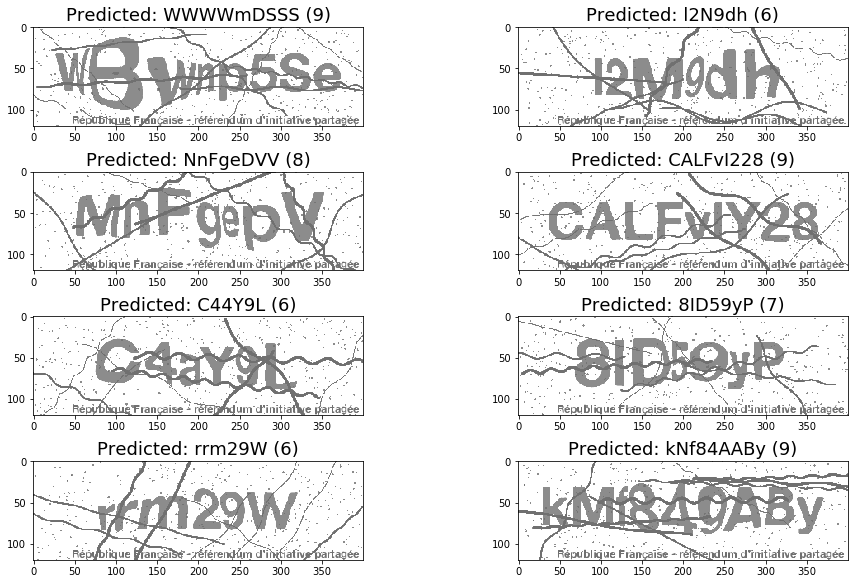

In [2]:
# Test predictions on randomly downloaded captcha images.

# Load tokenizer and model
tokenizer = tfds.features.text.TokenTextEncoder.load_from_file(str(tokenizer_path))
model = tf.keras.models.load_model(str(model_path))

# Download images
batch_size = 8
captcha_url = "https://www.referendum.interieur.gouv.fr/bundles/ripconsultation/securimage/securimage_show.php"
images = [np.array(Image.open(io.BytesIO(requests.get(captcha_url).content))) for _ in trange(batch_size)]
images = np.array(images)

# Preprocess the image
batch = tf.cast(images, 'float32')
batch = tf.image.per_image_standardization(batch)

# Run inference
labels = model(batch)

# Postprocess results (decode labels)
labels = tf.argmax(labels, axis=2)
labels = [tokenizer.decode(label) for label in labels]
labels = [label.replace(' ', '').replace('0', '') for label in labels]

fig_size = 2
ncols = 2
nrows = batch_size // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * fig_size * ratio, fig_size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, ax, label in zip(images, axs, labels):
  ax.imshow(image)
  text = f'Predicted: {label} ({len(label)})'
  ax.set_title(text, fontsize=18)

---

Here we try to solve the captcha by postinf the captcha answer to the website.

In [ ]:
# Load tokenizer and model
tokenizer = tfds.features.text.TokenTextEncoder.load_from_file(str(tokenizer_path))
model = tf.keras.models.load_model(str(model_path))

def captcha_solver(image):
    
  image = np.array(image)
  images = np.array([image])
  
  # Preprocess the image
  batch = tf.cast(images, 'float32')
  batch = tf.image.per_image_standardization(batch)

  # Run inference
  labels = model(batch)

  # Postprocess results (decode labels)
  labels = tf.argmax(labels, axis=2)
  labels = [tokenizer.decode(label) for label in labels]
  labels = [label.replace(' ', '').replace('0', '') for label in labels]
  
  return labels[0]


root_url = "https://www.referendum.interieur.gouv.fr/consultation_publique/8/"
url = urlparse.urljoin(root_url, 'A/AA')

n = 100
success = 0

for i in trange(n):

  cookies = {}
  cookies['incap_ses_1226_2043128'] = 'mgkMA9/hwWCLbdgBuaADEStnJl0AAAAA+VteaHrdbEO+DT3swlExCA=='
  session = requests.Session()
  requests.utils.add_dict_to_cookiejar(session.cookies, cookies)

  req = session.get(url)
  response = TextResponse(str(req.url), body=req.text, encoding='utf-8')

  captcha = response.css('img#captcha').xpath('@src').get()

  if not captcha:
    raise Exception("Captcha not here.")

  # Get the token
  token = response.css('#form__token').xpath('@value').get()

  # Get the image captcha URL
  captcha_uri = response.css('img#captcha').xpath('@src').get()
  captcha_url = urlparse.urljoin(root_url, captcha_uri)

  # Download the image
  req = session.get(captcha_url)
  captcha_image = Image.open(io.BytesIO(req.content))

  # Solve the captcha
  captcha_solution = captcha_solver(captcha_image)

  # Send captcha solution.
  form_data = {}
  form_data['form[captcha]'] = captcha_solution
  form_data['form[_token]'] = token

  # Get the actual page.
  req = session.post(url, data=form_data)
  response = TextResponse(str(req.url), body=req.text, encoding='utf-8')

  captcha = response.css('img#captcha').xpath('@src').get()

  if not captcha:
    success += 1

In [43]:
(success / n) * 100

'aTRDAb'